# Finding stars in CLIO images

bditools.findstars_in_dataset takes in a CLIO dataset and finds the (x,y) subpixel location of point sources in the image using DAOStarFinder (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html).    User supplies the path to a folder containing every skysubtracted image to search (with subscript "skysub" in filename, see cliotools.skysub doc), the integer (x,y) pixel location of a point source (preferably the brightest) in the first image in the list to use as a template, and the number of point sources in the image to search for.  findstars makes a template of the psf of the supplied point source, and for each image: <br>
- performs a cross correlation of the template with the image<br>
- finds the location of the max value in the cross correlation<br>
- uses DAOStarFinder to find the subpixel location of the star at that spot<br>
- masks that star and finds the next largest cross correlation location and uses DAOStarFinder there, then masks that location <br>
- continues to mask and DAOStarFind until the requested number of stars in the image have been found. <br>

When all stars have been found, the script writes the file name and location of all stars in x,y pairs in a file called "StarLocations".<br>
If DAOStarFinder fails to find all stars in the image, either due to poor SNR or distorted psf etc, the missing stars will be marked with nan and the row commented out with #

Dependencies: numpy, astropy, scipy, photutils

Written by Logan A. Pearce, 2020

In [1]:
from cliotools.bditools import findstars_in_dataset
help(findstars_in_dataset)

Help on function findstars_in_dataset in module cliotools.bditools:

findstars_in_dataset(dataset_path, nstars, xca, yca, corrboxsizex=40, corrboxsizey=40, boxsize=100, skip_list=False, append_file=False, threshold=10000.0, radius=20, fwhm=10)
    Find the subpixel location of stars A and B in a clio BDI dataset.
    Parameters:
    -----------
    dataset_path : string
        path to science images including image prefixes and underscores.  
        ex: An image set of target BDI0933 with filenames of the form BDI0933__00xxx.fit
            would take as input a path string of 'BDI0933/BDI0933__'
    xca, yca : int
        integer pixel locations of a star in the first image of the dataset, rough guess 
    corrrboxsize : int
        size of box to draw around star psfs for imstamp and cross correlation
    boxsize : int
        size of box to draw around star psfs for DAOStarFinder
    skip_list : bool
        By default script will make a list of all "skysub" images in given direct

Demonstration with provided example data set.  Image 9 and 13 have stars that are two faint to be detected, so we should expect the script to fail to find those stars and reject those images.

In [2]:
import numpy as np
# Specify path to dataset:
path = 'example_data/BD03884A_'
# Supply integer location of bright star in the first image in the dataset,
# which I have saved in a file called "initialguess"
rr = np.loadtxt(path.split('/')[0]+'/initialguess')
xca, yca= rr[0], rr[1]

# Specify parameters:
nstars = 2 # number of stars in image
corrboxsize = 40 # size of box to make image stamp for reference image. Smaller size is better
                 # for run time since it is performing a cross-correlation of a 2d image.
boxsize = 100 # size of box within which DAOStarFinder will search for a star
threshold = 1e4 # expected amplitude of star signal.
radius = 40 # radius for masking stars in image. A few times the fwhm is fine.
fwhm = 20 # approx fwhm for psf in image.

# Findstars in the dataset:
findstars_in_dataset(path, nstars, xca, yca, corrboxsizex = corrboxsize, corrboxsizey = corrboxsize,\
                     boxsize = boxsize, skip_list = False, \
                     append_file = False, threshold = threshold, radius = radius, fwhm = fwhm)

62.0% (8 of 13): |############--------|  Failed to find all stars.
Failed to find all stars.
92.0% (12 of 13): |##################--|  Failed to find all stars.
Failed to find all stars.
100% (13 of 13): |####################|  Done...
Done


## Reading in output:

In [3]:
# Using pandas (recommended):
readin = pd.read_csv('example_data/StarLocations', 
                     delim_whitespace = True, # Spaces separate items in the list
                     comment = '#', # Ignore commented rows
                     names=['filename', 'xca','yca', 'xcb', 'ycb'] # specify column names
                    )
readin

,filename,xca,yca,xcb,ycb
0,example_data/BD03884A_00001_skysub.fit,187.846049,234.709975,365.349491,153.924542
1,example_data/BD03884A_00002_skysub.fit,187.847250,234.765623,365.514127,154.481573
2,example_data/BD03884A_00003_skysub.fit,187.781005,235.037950,365.420980,155.148167
3,example_data/BD03884A_00004_skysub.fit,187.612027,235.191426,365.598349,155.552064
4,example_data/BD03884A_00005_skysub.fit,187.626527,235.140553,365.755288,155.769216
5,example_data/BD03884A_00006_skysub.fit,187.170087,235.303660,364.923006,156.358078
6,example_data/BD03884A_00007_skysub.fit,187.142453,235.544440,364.986451,156.610197
7,example_data/BD03884A_00008_skysub.fit,186.918615,235.926963,365.450547,157.502997
8,example_data/BD03884A_00010_skysub.fit,186.768840,235.850013,365.222143,157.966508
9,example_data/BD03884A_00011_skysub.fit,733.930551,288.323377,914.288672,210.662894


In [5]:
# Using Numpy.genfromtxt.  This removes the filenames
readin = np.genfromtxt('example_data/StarLocations')
readin

array([[         nan, 187.84604886, 234.70997452, 365.34949105,
        153.92454164],
       [         nan, 187.84725019, 234.76562262, 365.51412665,
        154.48157349],
       [         nan, 187.78100505, 235.03795   , 365.42098047,
        155.14816719],
       [         nan, 187.61202664, 235.19142607, 365.59834928,
        155.55206381],
       [         nan, 187.62652737, 235.14055297, 365.75528803,
        155.76921582],
       [         nan, 187.17008665, 235.30365988, 364.92300572,
        156.35807824],
       [         nan, 187.14245349, 235.54444013, 364.98645149,
        156.61019679],
       [         nan, 186.91861478, 235.92696258, 365.45054733,
        157.50299652],
       [         nan, 186.76884   , 235.85001269, 365.22214261,
        157.96650835],
       [         nan, 733.93055107, 288.32337661, 914.28867194,
        210.66289363],
       [         nan, 733.38350963, 289.50241287, 913.81590094,
        211.89708571]])

In [6]:
# To preserve column names:
readin = np.genfromtxt('example_data/StarLocations', usecols=(1,2,3,4))
readin_names = np.genfromtxt('example_data/StarLocations', usecols=(0), dtype=str)
for i in range(len(readin)):
    print(readin_names[i],readin[i])


example_data/BD03884A_00001_skysub.fit [187.84604886 234.70997452 365.34949105 153.92454164]
example_data/BD03884A_00002_skysub.fit [187.84725019 234.76562262 365.51412665 154.48157349]
example_data/BD03884A_00003_skysub.fit [187.78100505 235.03795    365.42098047 155.14816719]
example_data/BD03884A_00004_skysub.fit [187.61202664 235.19142607 365.59834928 155.55206381]
example_data/BD03884A_00005_skysub.fit [187.62652737 235.14055297 365.75528803 155.76921582]
example_data/BD03884A_00006_skysub.fit [187.17008665 235.30365988 364.92300572 156.35807824]
example_data/BD03884A_00007_skysub.fit [187.14245349 235.54444013 364.98645149 156.61019679]
example_data/BD03884A_00008_skysub.fit [186.91861478 235.92696258 365.45054733 157.50299652]
example_data/BD03884A_00010_skysub.fit [186.76884    235.85001269 365.22214261 157.96650835]
example_data/BD03884A_00011_skysub.fit [733.93055107 288.32337661 914.28867194 210.66289363]
example_data/BD03884A_00012_skysub.fit [733.38350963 289.50241287 913.

## Checking your work:

<IPython.core.display.Javascript object>


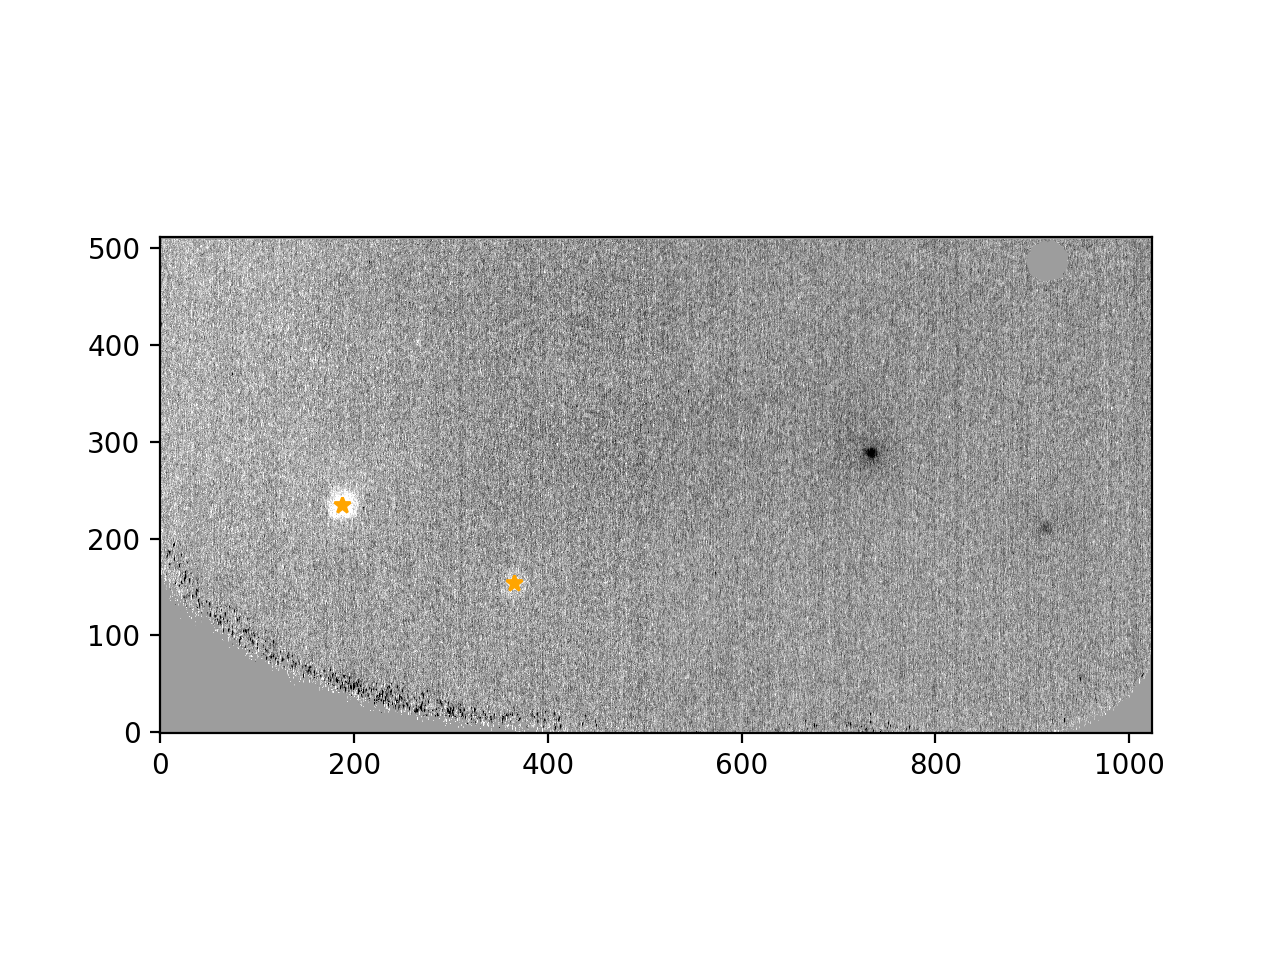

In [10]:
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits
image = fits.getdata(readin_names[0])
%matplotlib notebook
plt.imshow(image, origin='lower',cmap='gray',norm = ImageNormalize(image, interval=ZScaleInterval(),))
plt.plot(readin[0,0], readin[0,1], marker='*',color='orange', ls='None')
plt.plot(readin[0,2], readin[0,3], marker='*',color='orange', ls='None')
plt.show()